In [2]:
import os 
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import splitfolders

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report, confusion_matrix

<a id='4'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Extraction </h2> </div>
In this part we are going to extract an image of each class we have.

In [3]:
# Path where our data is located
base_path = "./Dataset_SLR/asl_dataset/"

# Dictionary to save our 36 classes
categories = {  0: "0",
                1: "1",
                2: "2",
                3: "3",
                4: "4",
                5: "5",
                6: "6",
                7: "7",
                8: "8",
                9: "9",
                10: "a",
                11: "b",
                12: "c",
                13: "d",
                14: "e",
                15: "f",
                16: "g",
                17: "h",
                18: "i",
                19: "j",
                20: "k",
                21: "l",
                22: "m",
                23: "n",
                24: "o",
                25: "p",
                26: "q",
                27: "r",
                28: "s",
                29: "t",
                30: "u",
                31: "v",
                32: "w",
                33: "x",
                34: "y",
                35: "z",
            }

def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(
        lambda x: x[re.search("_", x).start() + 1 : re.search("_", x).start() + 2]
        + "/"
        + x
    )
    return df


# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(base_path + categories[category])
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({"filename": filenames_list, "category": categories_list})
df = add_class_name_prefix(df, "filename")

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

In [4]:
df

filename  category
0       2/hand2_2_dif_seg_1_cropped.jpeg         2
1     3/hand1_3_right_seg_1_cropped.jpeg         3
2       v/hand4_v_bot_seg_5_cropped.jpeg        31
3       e/hand3_e_dif_seg_5_cropped.jpeg        14
4       m/hand2_m_top_seg_2_cropped.jpeg        22
...                                  ...       ...
2510  m/hand1_m_right_seg_4_cropped.jpeg        22
2511   b/hand2_b_left_seg_1_cropped.jpeg        11
2512    g/hand5_g_dif_seg_2_cropped.jpeg        16
2513   i/hand2_i_left_seg_3_cropped.jpeg        18
2514    c/hand2_c_bot_seg_3_cropped.jpeg        12

[2515 rows x 2 columns]

In [5]:
print("number of elements = ", len(df))

number of elements =  2515


<a id='5'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Exploration </h2> </div>

First, we start by visualizing the variable of interest.

Let's view more images in a grid format.

<h5 style="text-align:center;color:Green">We visualize few images of ASL. </h5>

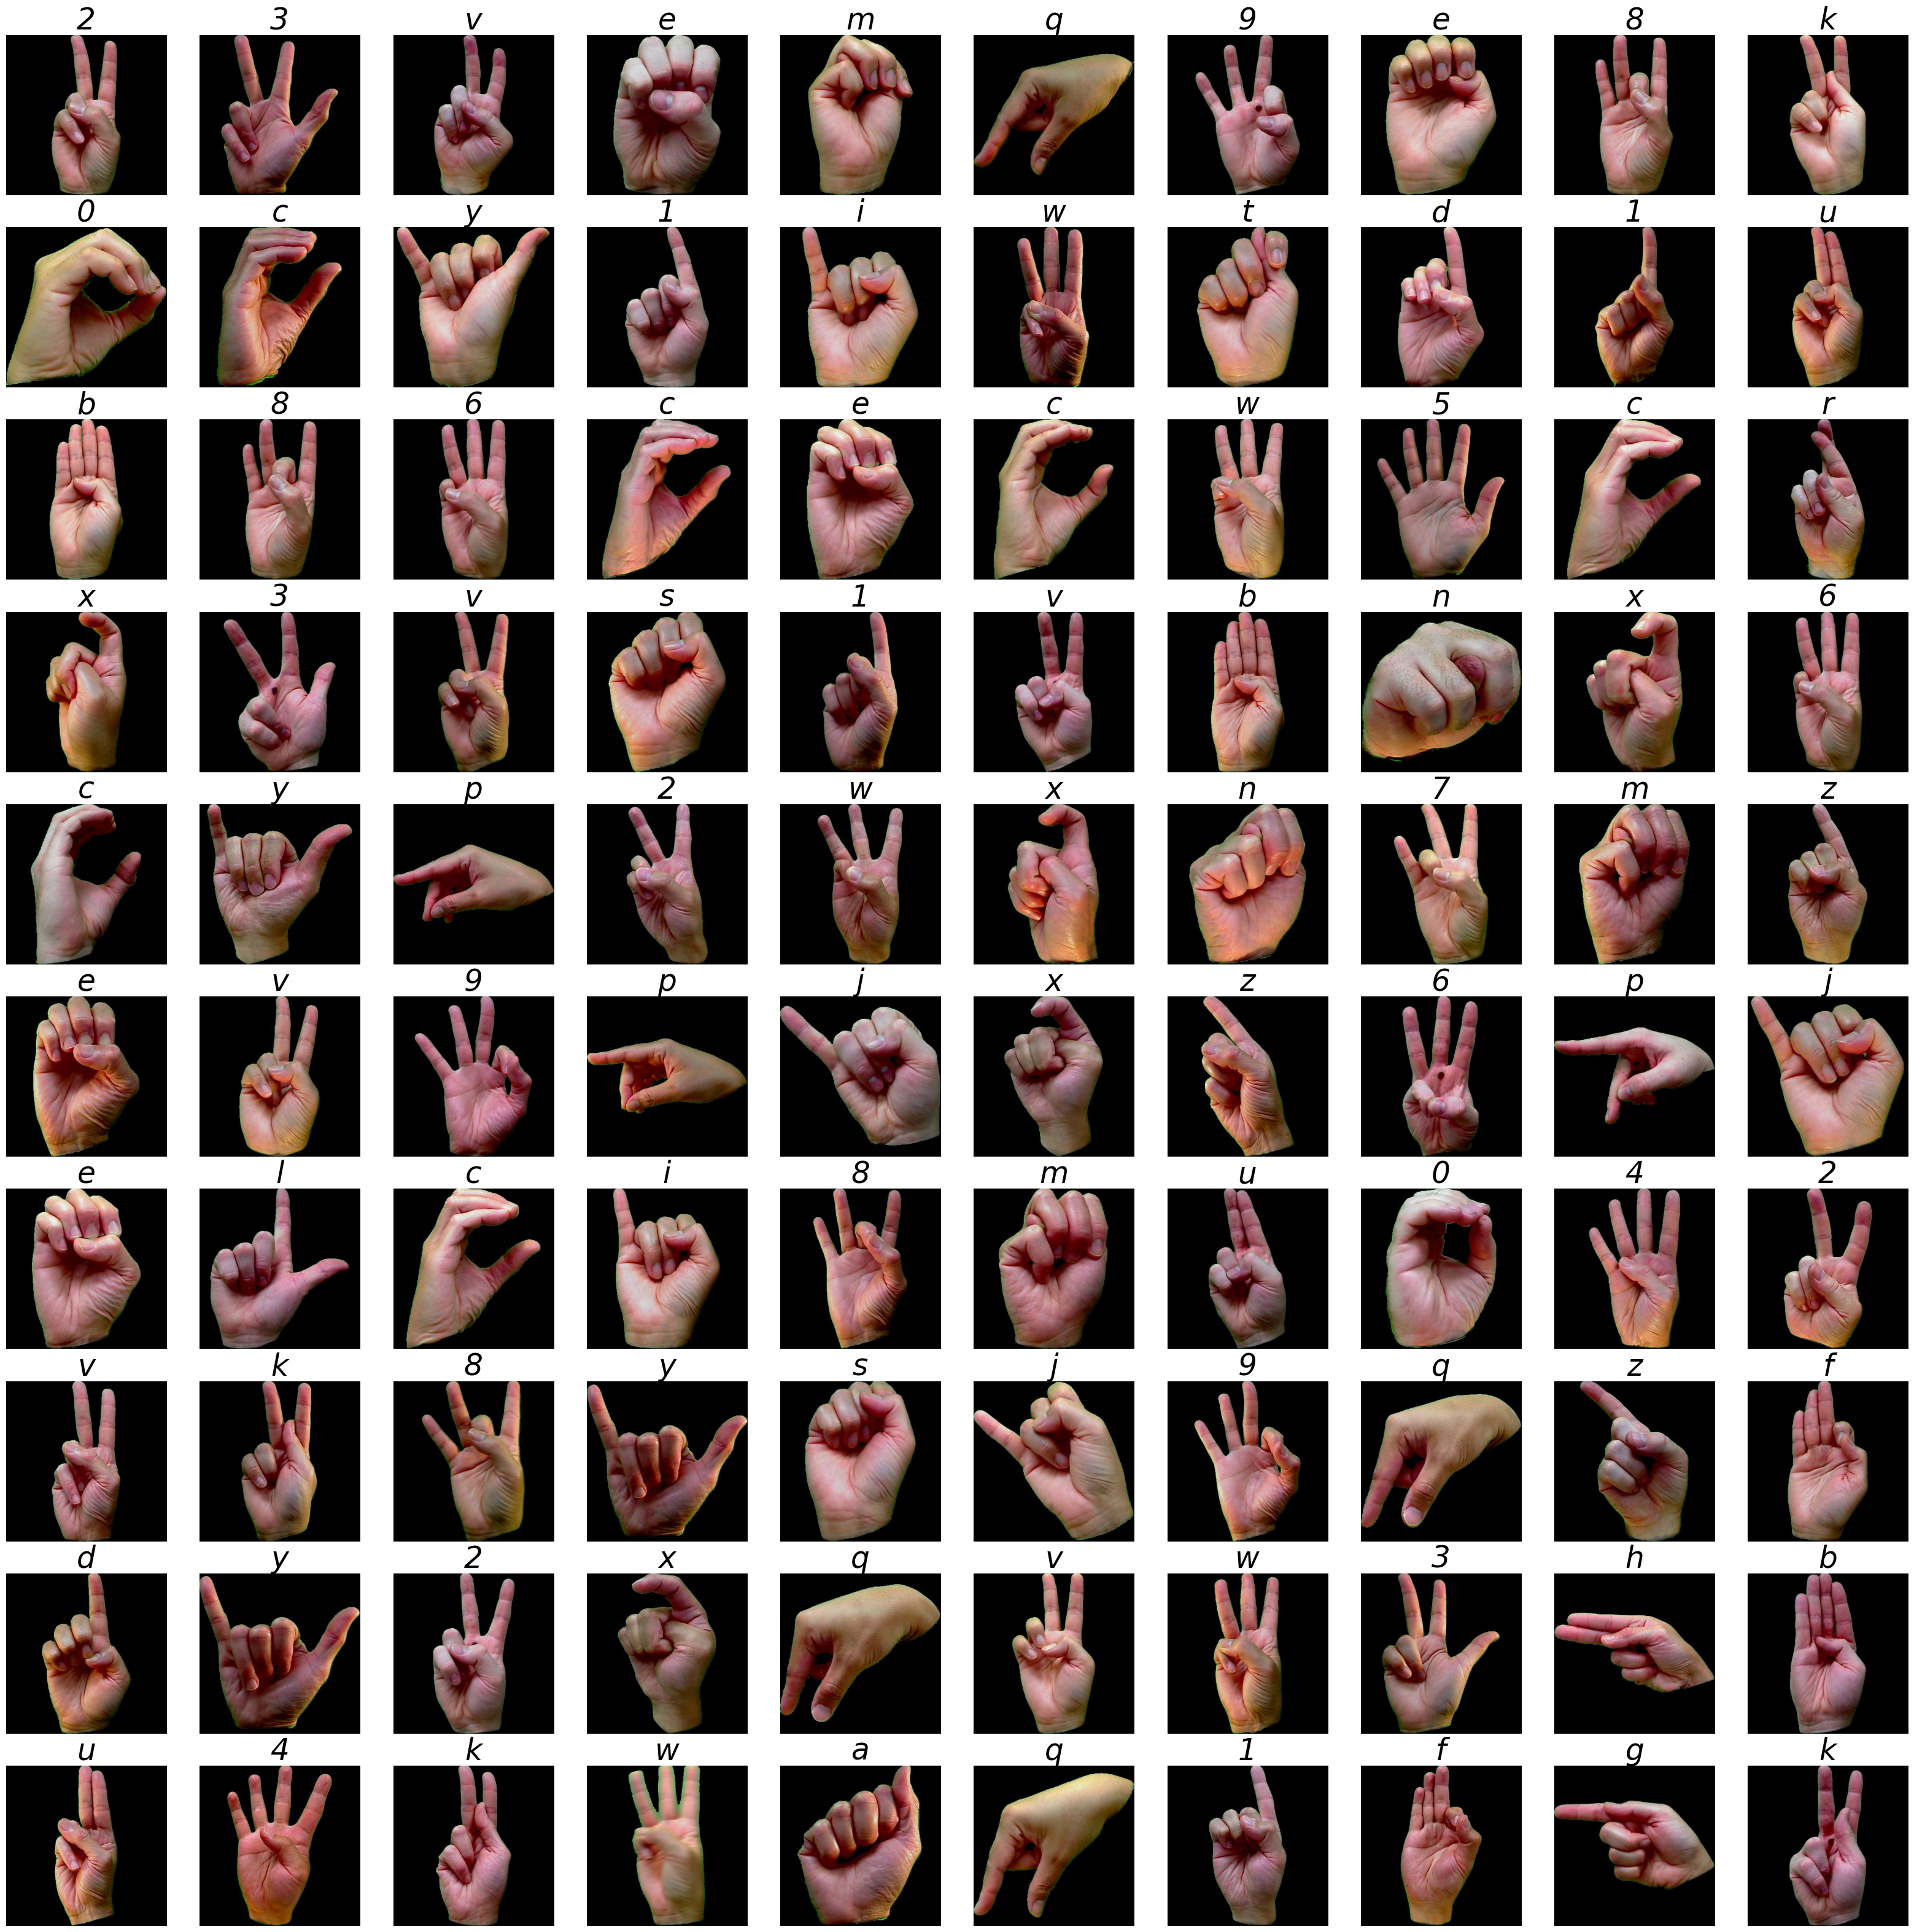

In [6]:
plt.figure(figsize=(40,40))

for i in range(100):
    path = base_path + df.filename[i]
    img = plt.imread(path)
    plt.subplot(10,10, i + 1)
    plt.imshow(img)
    plt.title(categories[df.category[i]],fontsize=35,fontstyle='italic')
    plt.axis("off")

Now, we will see the distrubution of data in every class.

C:\Users\jonua\AppData\Local\Temp\ipykernel_22916\842432032.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)


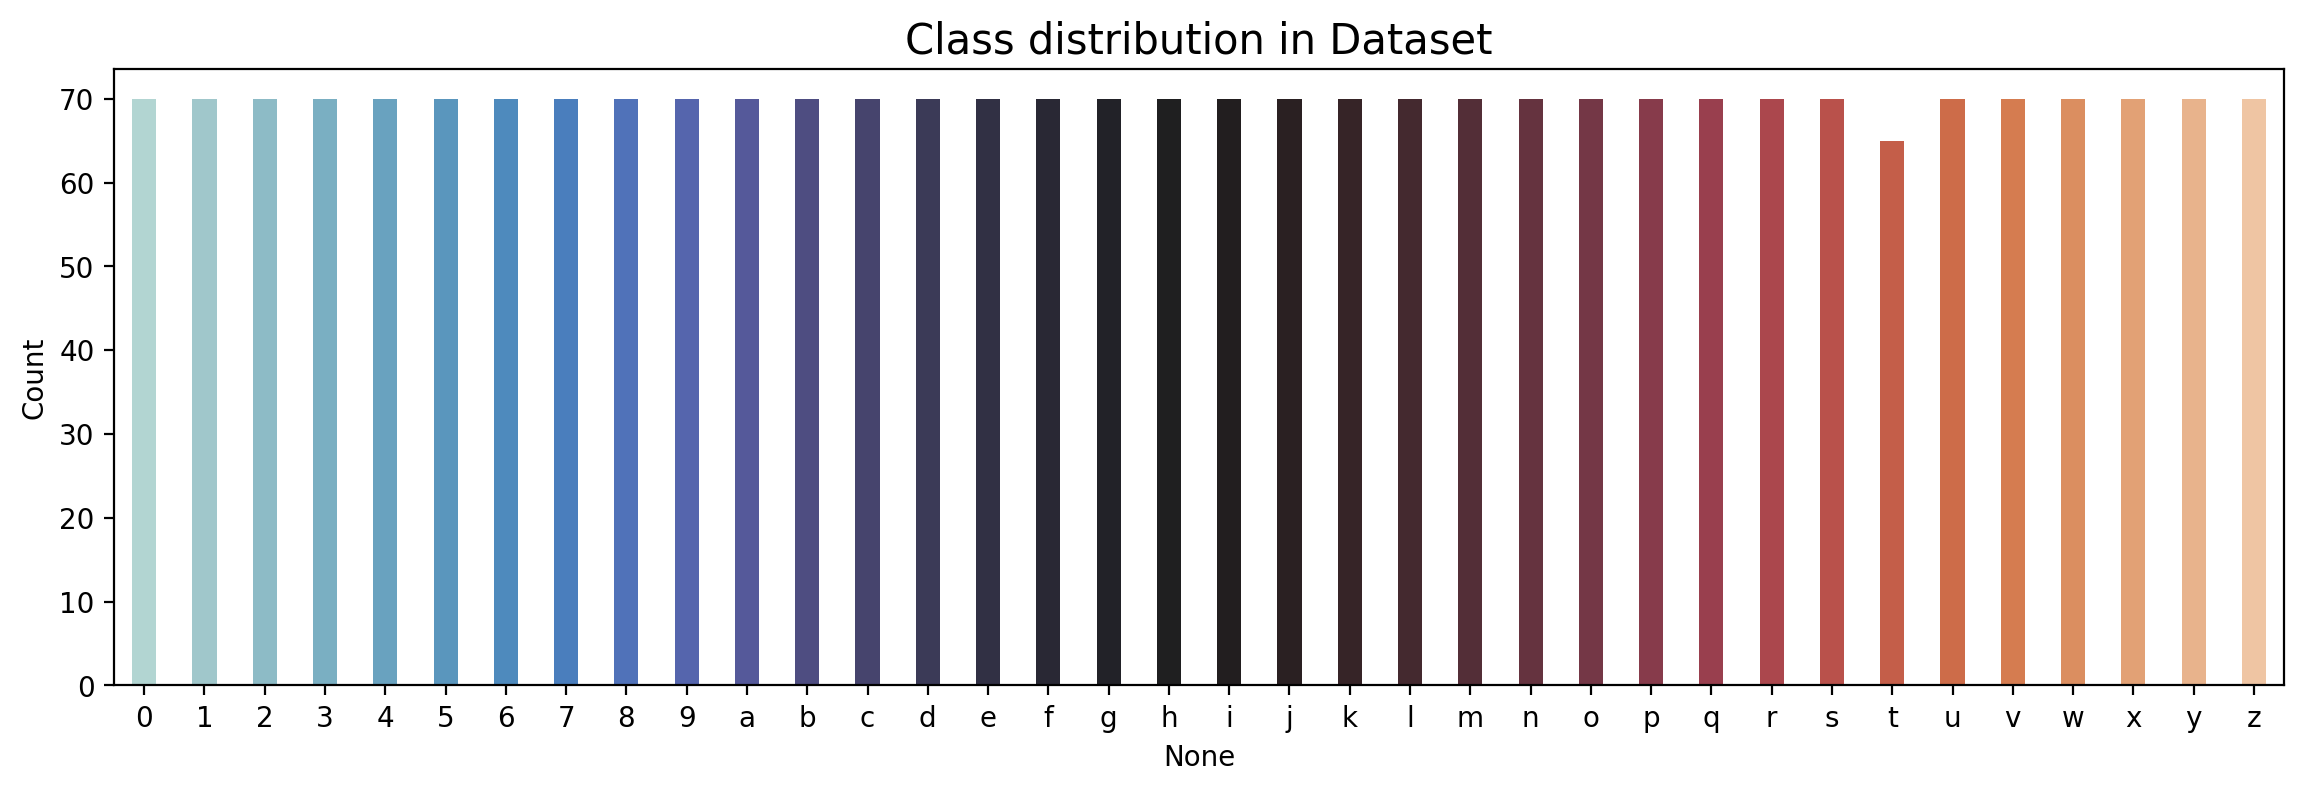

In [7]:
label,count = np.unique(df.category,return_counts=True)
uni = pd.DataFrame(data=count,index=categories.values(),columns=['Count'])

plt.figure(figsize=(14,4),dpi=200)
sns.barplot(data=uni,x=uni.index,y='Count',palette='icefire',width=0.4).set_title('Class distribution in Dataset',fontsize=15)
plt.show()

<a id='6'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Train Test Split </h2> </div>

We will split the data in three parts.
* Training dataset (80%)
* Validation dataset (10%)
* Testing dataset (10%)

In [8]:
import splitfolders

# Ensure the input directory structure is correct
input_dir = base_path
output_dir = 'working/'

# Split the dataset
splitfolders.ratio(input_dir, output=output_dir, seed=1333, ratio=(0.8, 0.1, 0.1))

<a id='7'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Data Preparation </h2> </div>

<a id='8'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black">Image Data Generator </h3> </div>

* The data for will used by flow_from_directory.
* The batch size is 32 and the image size is (200, 200).
* The Image Data Generator will be used to rescale the images.

In [9]:
datagen = ImageDataGenerator(rescale= 1.0 / 255)

Finally, we will list out all the important parameters and respective values.

In [10]:
train_path = 'working/train'
val_path = 'working/val'
test_path = 'working/test'

batch = 32
image_size = 200
img_channel = 3
n_classes = 36

<a id='9'></a>
<div class="alert alert-block alert-warning"><h4 style="text-align:center;color:black"> Flow from Directory </h4> </div>

* We will import the data from directory.
* we will set **shuffle = False** for test data.

In [11]:
train_data = datagen.flow_from_directory(directory=train_path, 
                                         target_size=(image_size, image_size), 
                                         batch_size=batch, 
                                         class_mode='sparse')

val_data = datagen.flow_from_directory(directory=val_path, 
                                       target_size=(image_size, image_size), 
                                       batch_size=batch, 
                                       class_mode='sparse')

test_data = datagen.flow_from_directory(directory=test_path, 
                                        target_size=(image_size, image_size), 
                                        batch_size=batch, 
                                        class_mode='sparse', 
                                        shuffle=False)

Found 2012 images belonging to 36 classes.
Found 251 images belonging to 36 classes.
Found 252 images belonging to 36 classes.


<a id='10'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Deep Learning Model </h2> </div>



### Architecture

The architecture of the American Sign Langauge Image Classification model consists of the following Layers and components:

#### Layers :
* The input layer consist of a Conv2D with 32 filters and activation relu.
* The model contain the 3 blocks of convolution with increasing filters and activation relu.
* Each convolution block contains Max pooling (pool_size = 2) and Dropout (0.2).
* The fully connected layers contain Flatten layer, Dense layer with 512 units and a Dropout layer.
* The output layer is a Dense layer with 36 units and softmax activation.

#### Components:

* **Input Layer:** Receives input images for classification.
* **Convolutional Layers:** Extract features from the images through convolutional operations.
* **Pooling Layers:** Reduce the spatial dimensions of the feature maps.
* **Flatten Layer:** Convert the 2D feature maps into a 1D vector.
* **Fully Connected Layers:** Perform classification using densely connected layers.
* **Output Layer:** Provides the final prediction probabilities for cat and dog classes.

In [12]:
model = Sequential()
# input layer
# Block 1
model.add(Conv2D(32,3,activation='relu',padding='same',input_shape = (image_size,image_size,img_channel)))
model.add(Conv2D(32,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.2))

# Block 2
model.add(Conv2D(64,3,activation='relu',padding='same'))
model.add(Conv2D(64,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.3))

#Block 3
model.add(Conv2D(128,3,activation='relu',padding='same'))
model.add(Conv2D(128,3,activation='relu',padding='same'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(padding='same'))
model.add(Dropout(0.4))

# fully connected layer
model.add(Flatten())

model.add(Dense(512,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))

# output layer
model.add(Dense(36, activation='softmax'))



model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 64)      36928     
                                                        

<a id='12'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Callbacks </h3> </div>
we will be using two callbacks -

* **ReduceLROnPlateau :** Reduce learning rate when a metric has stopped improving.
* **EarlyStopping :** Stop training when a monitored metric has stopped improving.

In [13]:
early_stoping = EarlyStopping(monitor='val_loss', 
                              min_delta=0.001,
                              patience= 5,
                              restore_best_weights= True, 
                              verbose = 0)

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy', 
                                         patience = 2, 
                                         factor=0.5 , 
                                         verbose = 1)

<a id='13'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Compile the model </h3> </div>
Finally we will compile the model .There are 3 things to mention here : Optimizer, Loss, Metrics

* **Optimizer** :- To minimize cost function we use different methods For ex :- like gradient descent, stochastic gradient descent. So these are call optimizers. We are using a default one here which is adam.
​
* **Loss** :- To make our model better we either minimize loss or maximize accuracy. Neural Networks always minimize loss. To measure it we can use different formulas like 'sparse_categorical_crossentropy', 'categorical_crossentropy' or 'binary_crossentropy'. Here I have used 'sparse_categorical_crossentropy'.
​
* **Metrics** :- This is to denote the measure of your model. Can be accuracy or some other metric.

In [14]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy' , metrics=['accuracy'])

<a id='14'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Fit the model </h3> </div>

We are now going to train our compiled model using the train data and use the val data as a validation dataset during training.

The number of steps for the train and validation iterators must be specified. This is the number of batches that will comprise one epoch. This can be specified via the length of each iterator, and will be the total number of images in the train and validation directories divided by the batch size (32).

The model will be fit for 30 epochs.

In [15]:
asl_class = model.fit(train_data, 
                      validation_data= val_data, 
                      epochs=30, 
                      callbacks=[early_stoping,reduce_learning_rate],
                      verbose = 1)

Epoch 1/30
63/63 [==============================] - 61s 727ms/step - loss: 2.7345 - accuracy: 0.2629 - val_loss: 0.8164 - val_accuracy: 0.7610 - lr: 0.0010
Epoch 2/30
63/63 [==============================] - 39s 616ms/step - loss: 0.7470 - accuracy: 0.7694 - val_loss: 0.2427 - val_accuracy: 0.9124 - lr: 0.0010
Epoch 3/30
63/63 [==============================] - 40s 622ms/step - loss: 0.3243 - accuracy: 0.8912 - val_loss: 0.1672 - val_accuracy: 0.9243 - lr: 0.0010
Epoch 4/30
63/63 [==============================] - 40s 620ms/step - loss: 0.2313 - accuracy: 0.9240 - val_loss: 0.1601 - val_accuracy: 0.9402 - lr: 0.0010
Epoch 5/30
63/63 [==============================] - 40s 624ms/step - loss: 0.1523 - accuracy: 0.9528 - val_loss: 0.0945 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/30
63/63 [==============================] - 41s 636ms/step - loss: 0.1022 - accuracy: 0.9682 - val_loss: 0.0931 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/30
63/63 [==============================] - ETA: 0s - lo

<a id='15'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Evaluvation </h3> </div>

we will evaluvate the Training and validation data accuracy and loss.

In [16]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_data , verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_data, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 99.9502956867218
The Loss of the model for training data is: 0.001340866438113153
The accuracy of the model for validation data is: 96.81274890899658
The Loss of the model for validation data is: 0.0838967114686966


<a id='16'></a>
<div class="alert alert-block alert-danger"><h3 style="text-align:center;color:black"> Plot the results </h3> </div>

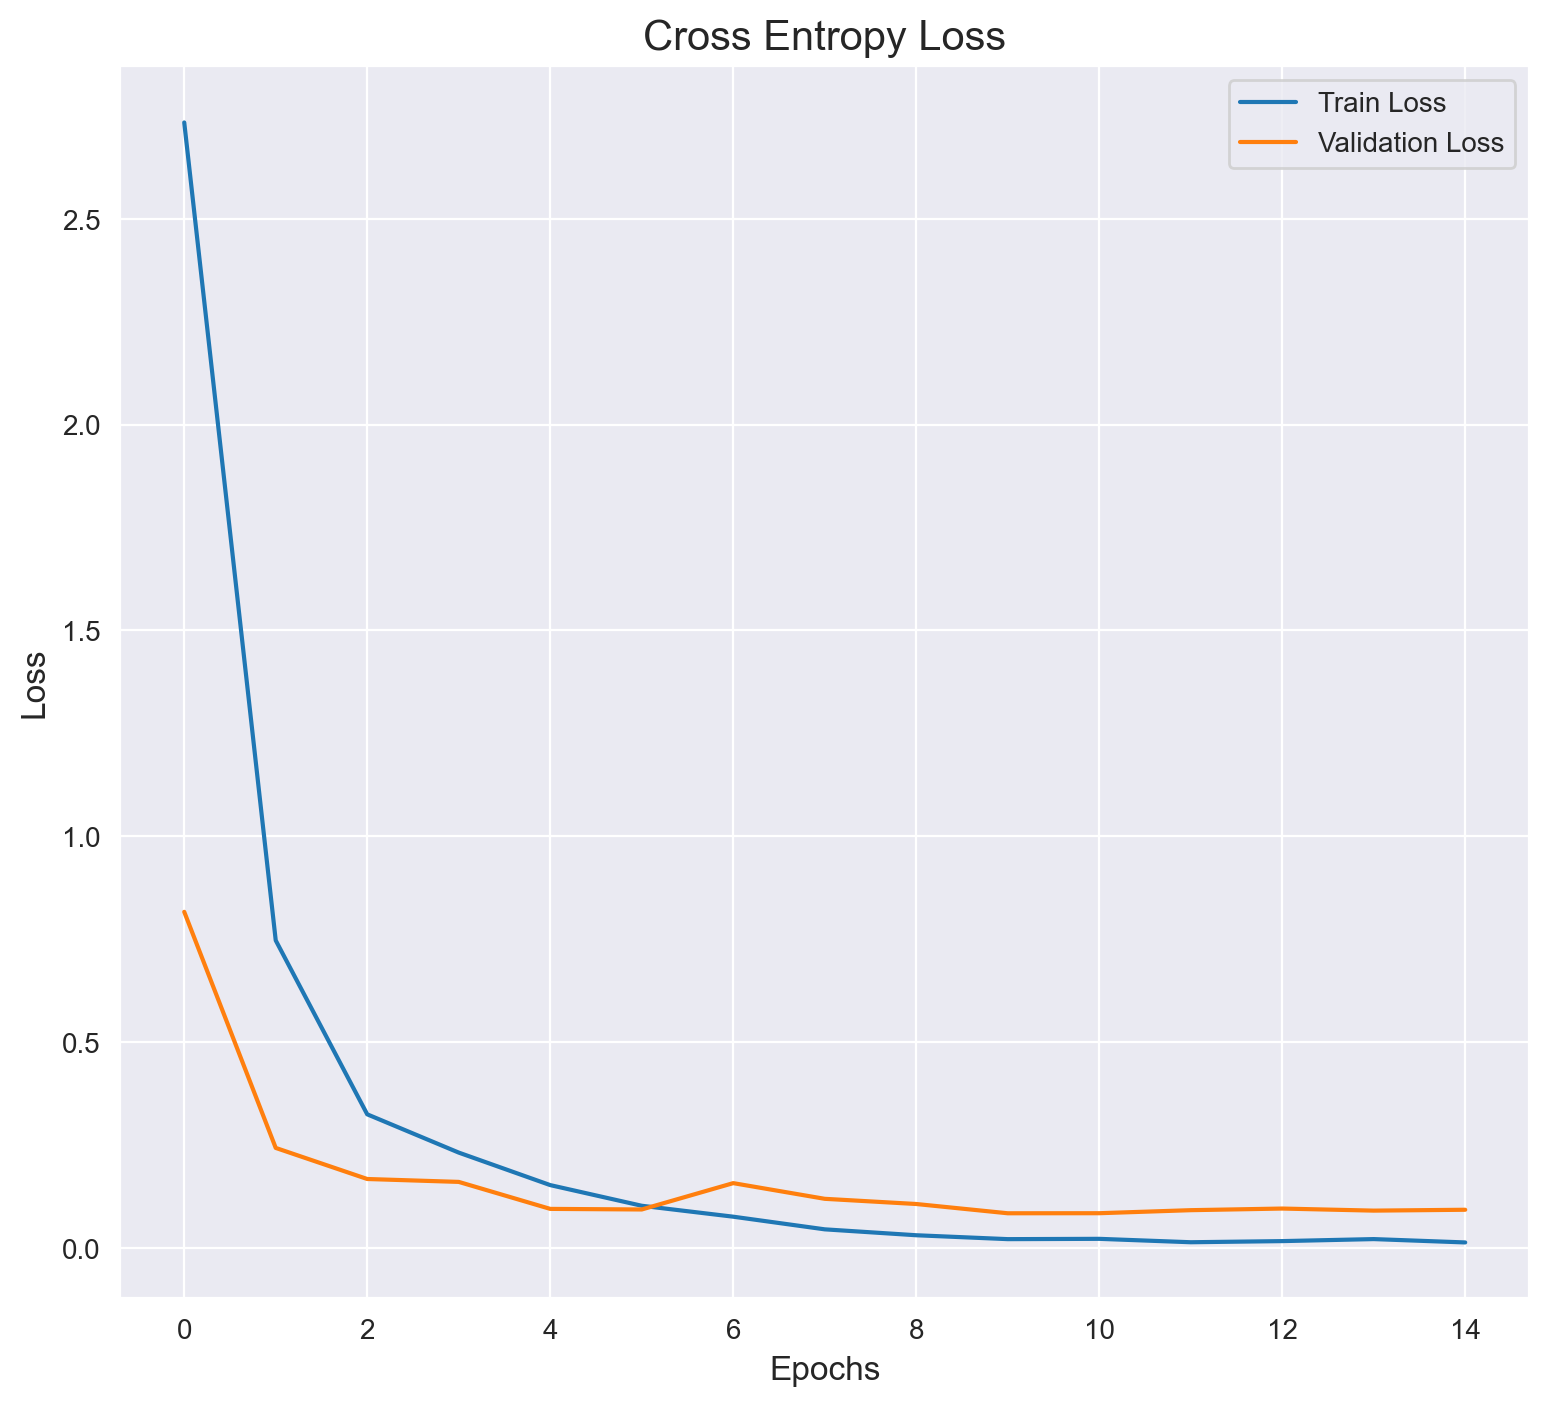

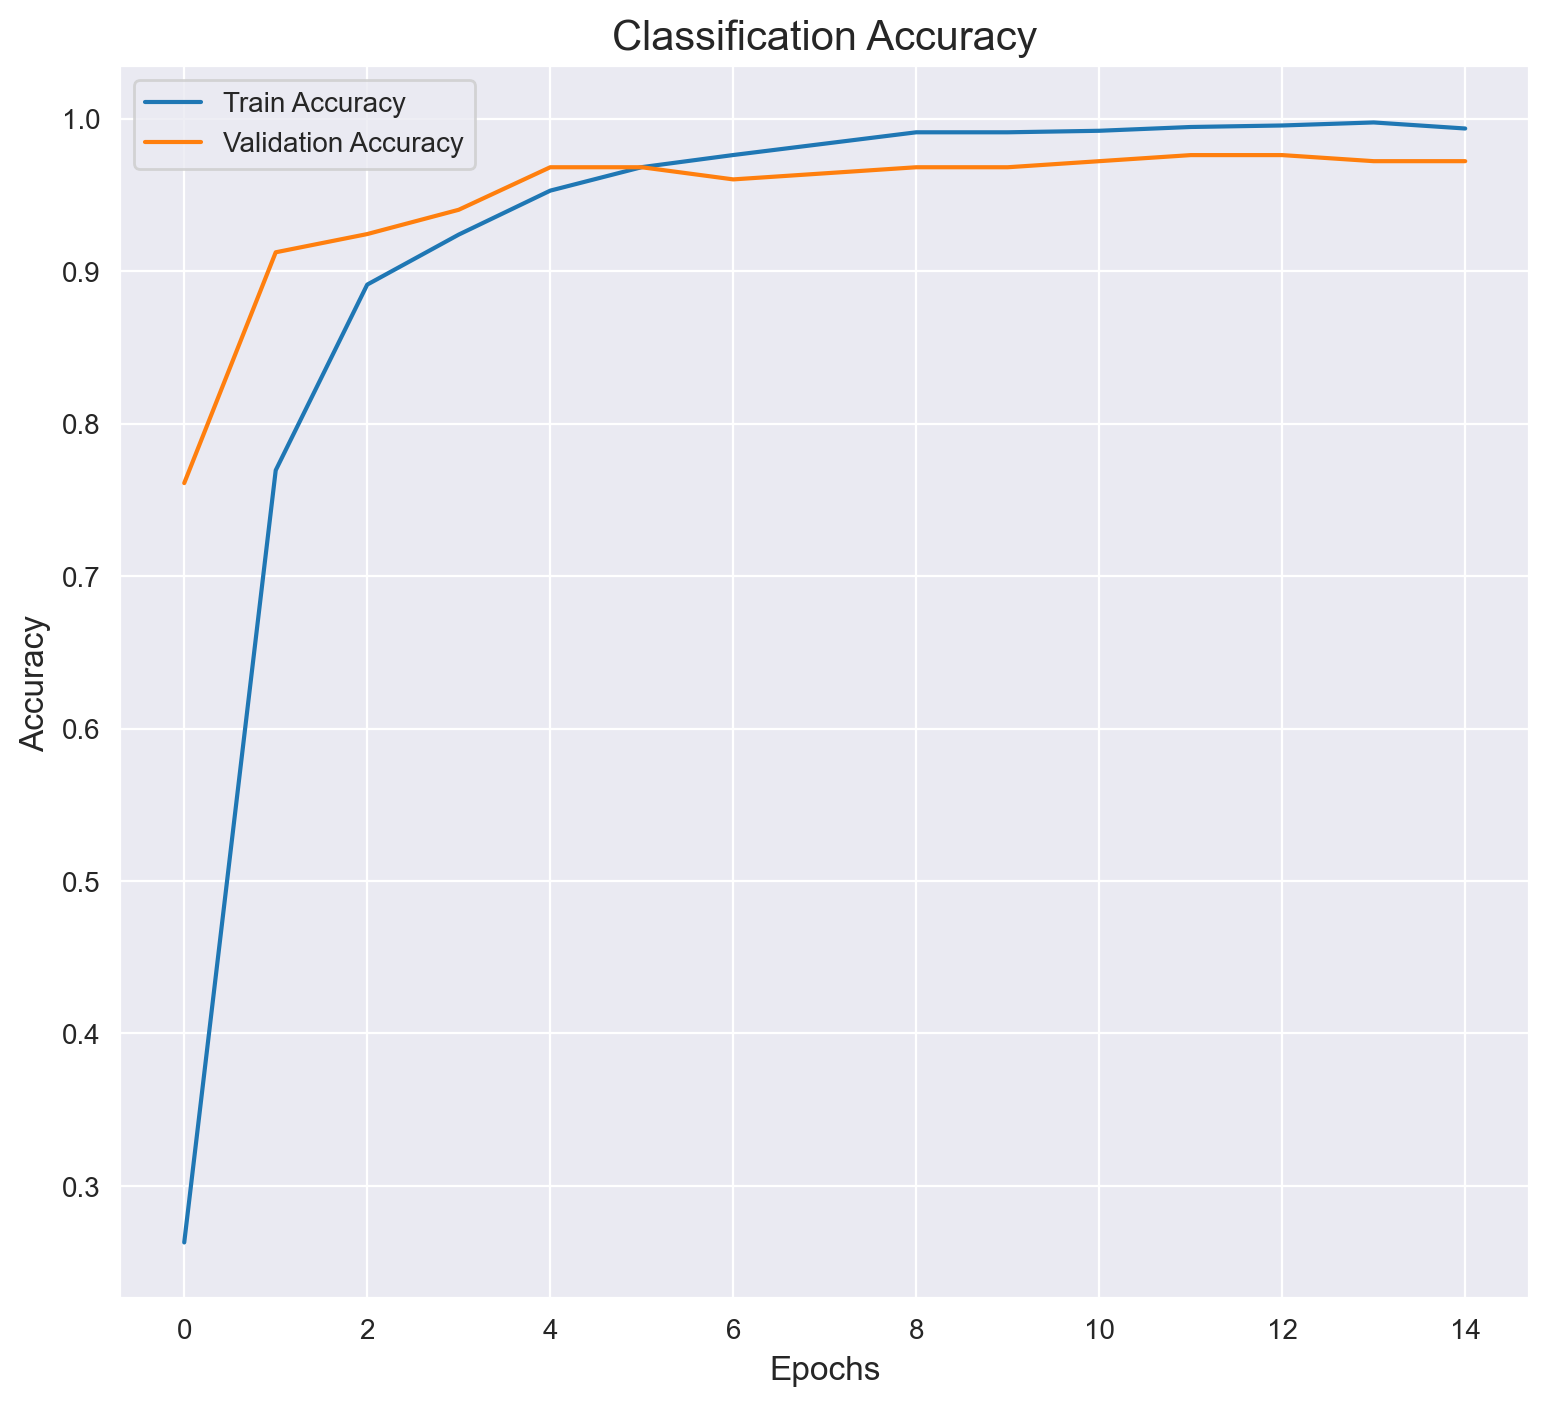

In [26]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(asl_class.history)

plt.figure(figsize=(20, 8), dpi=200)
sns.set_style('darkgrid')

# Plot for Cross Entropy Loss
plt.subplot(1, 2, 1)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error['loss'], label='Train Loss')
plt.plot(error['val_loss'], label='Validation Loss')
plt.legend()

plt.show()

# Plot for Classification Accuracy
plt.figure(figsize=(20, 8), dpi=200)
sns.set_style('darkgrid')

plt.subplot(1, 2, 2)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error['accuracy'], label='Train Accuracy')
plt.plot(error['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.show()

<a id='17'></a>
<div class="alert alert-block alert-info"><h2 style="text-align:center;color:black"> Prediction </h2> </div>

Now, we will predict the labels for the test data which will give us clear idea about the accuracy of the model.


In [18]:
# prediction
result = model.predict(test_data,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_data.labels

# Evaluvate
loss,acc = model.evaluate(test_data,verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 94.44444179534912
The Loss of the model for testing data is: 0.318569153547287


The count of correctly and incorrectly classified images.

In [19]:
p = y_pred
y = y_true
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 238
Incorrect predicted classes: 14


Classification report

In [20]:
print(classification_report(y_true, y_pred,target_names= categories.values()))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.88      1.00      0.93         7
           2       0.75      0.86      0.80         7
           3       1.00      1.00      1.00         7
           4       1.00      1.00      1.00         7
           5       1.00      1.00      1.00         7
           6       0.86      0.86      0.86         7
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00         7
           a       1.00      1.00      1.00         7
           b       1.00      0.86      0.92         7
           c       1.00      1.00      1.00         7
           d       1.00      1.00      1.00         7
           e       1.00      1.00      1.00         7
           f       1.00      1.00      1.00         7
           g       0.86      0.86      0.86         7
           h       1.00    

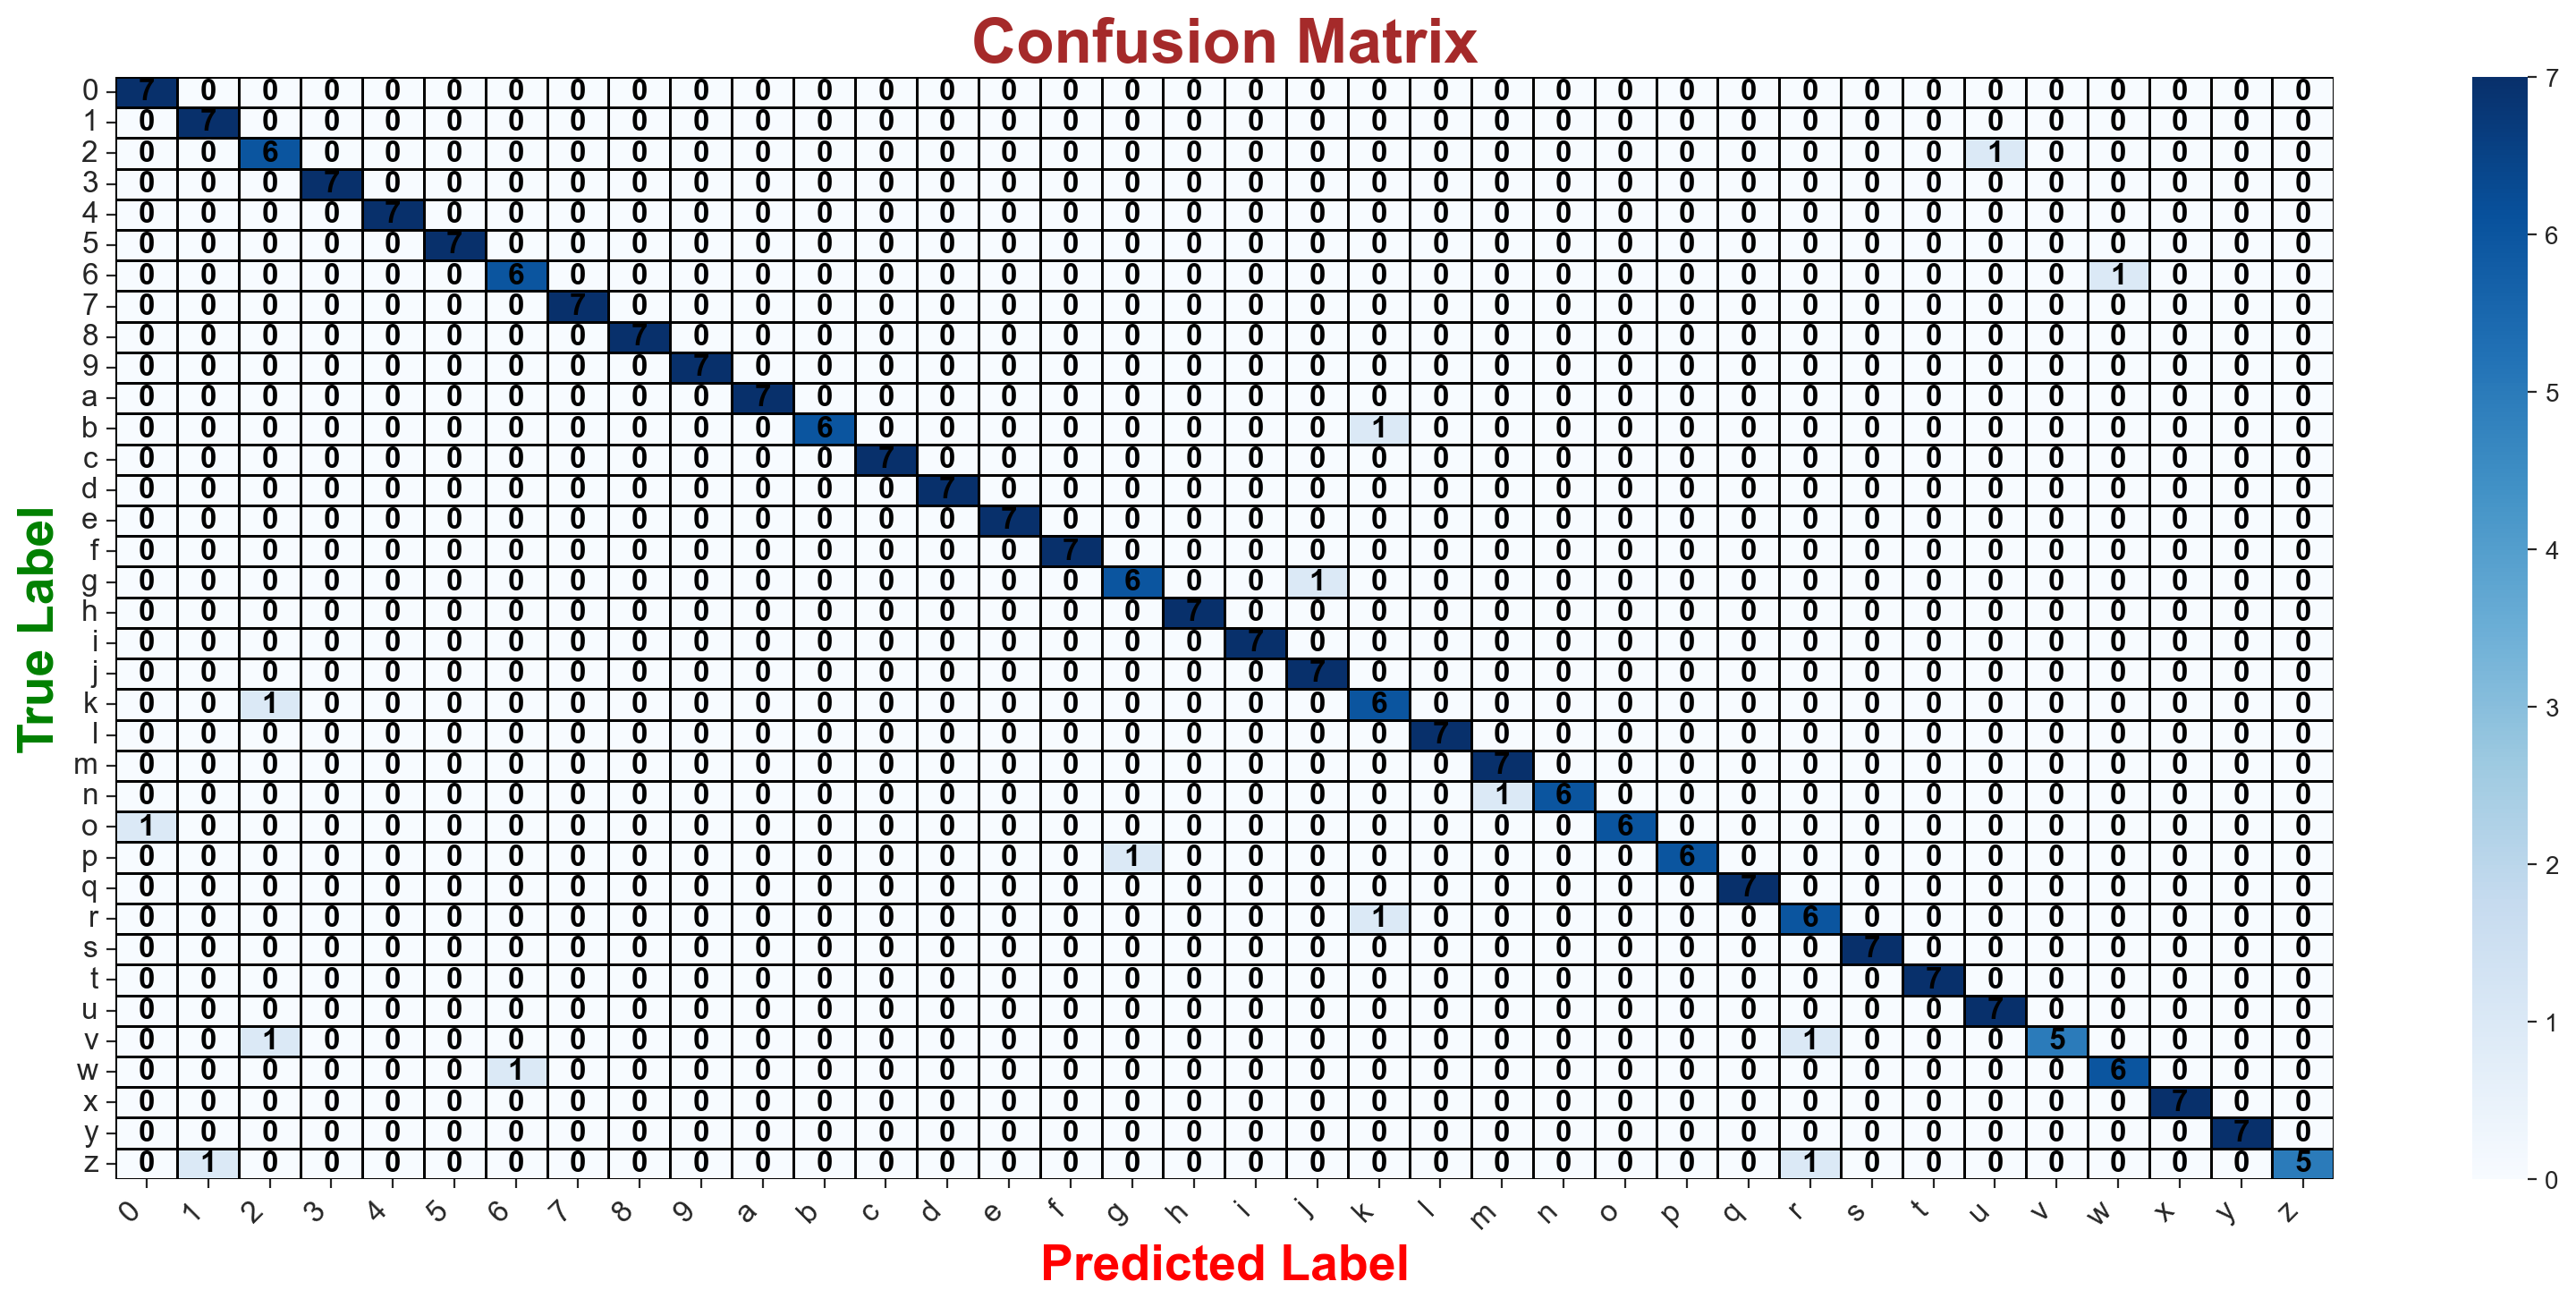

In [24]:
sns.set_style('ticks')

confusion_mtx = confusion_matrix(y_true,y_pred) 

f, ax = plt.subplots(figsize=(20, 8), dpi=200)

sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.5, cmap="Blues", 
            linecolor="black", fmt='.0f', ax=ax, 
            cbar=True, xticklabels=categories.values(), 
            yticklabels=categories.values(), 
            annot_kws={"size": 12, "weight": "bold", "color": "black"})

plt.xlabel("Predicted Label", fontdict={'color': 'red', 'size': 20, 'weight': 'bold'})
plt.ylabel("True Label", fontdict={'color': 'green', 'size': 20, 'weight': 'bold'})
plt.title("Confusion Matrix", fontdict={'color': 'brown', 'size': 25, 'weight': 'bold'})
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)

plt.show()

In [22]:
# model.save("ASL_model.h5")